In [1]:
# read input data

from sklearn.model_selection import train_test_split
import json
import pandas as pd

with open('train.json') as f:
    trainjson = json.load(f)

df_train = pd.io.json.json_normalize(trainjson)

# rebalance by under-sampling failures
df_received = df_train[df_train['requester_received_pizza'] == True]
df_not_received = df_train[df_train['requester_received_pizza'] == False]
df_not_received = df_not_received.sample(len(df_received))
df_train = pd.concat([df_not_received, df_received], axis=0)

df_train, df_valid = train_test_split(df_train, test_size=0.2)
print(f'Input datasets: train(N={len(df_train)}) and validation(N={len(df_valid)})')

with open('test.json') as f:
    testjson = json.load(f)

df_test = pd.io.json.json_normalize(testjson)

print(f'Test dataset: N={len(df_test)}')

Input datasets: train(N=1590) and validation(N=398)
Test dataset: N=1631


Analyzing traning set...
From N=1590 redditors, 789 got a random act of pizza. That's 49.62%!
Analyzing validation set...
From N=398 redditors, 205 got a random act of pizza. That's 51.51%!


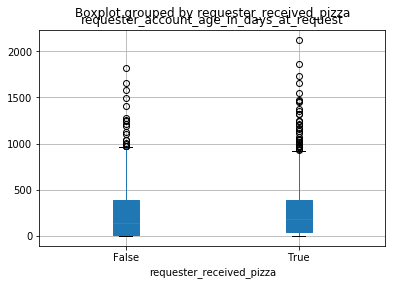

In [17]:
# print some stats...
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'

def count_acts_of_pizza(predictions):
    received = sum(predictions)
    success_rate = received / len(predictions) * 100
    print(f"From N={len(predictions)} redditors, {received} got a random act of pizza. That's {success_rate:.2f}%!")

print('Analyzing traning set...')
count_acts_of_pizza(df_train['requester_received_pizza'])
print('Analyzing validation set...')
count_acts_of_pizza(df_valid['requester_received_pizza'])


numeric_columns = [
    'requester_account_age_in_days_at_request',
]

for col in numeric_columns:
    df_train.boxplot(column=[col], by='requester_received_pizza', patch_artist=True)

In [3]:
# download nltk datasets

import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\axnsan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\axnsan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\axnsan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# stopwords to eliminate from the request body and text

from nltk.corpus import stopwords

import requests
import json
import string

stopwords_en = set(stopwords.words('english'))

stopwords_json_en = requests.get('https://raw.githubusercontent.com/6/stopwords-json/master/dist/en.json').json()
stopwords_json_en = set(stopwords_json_en)

stopwords_additional = {'...'}
stopwords_inconsistent = {"'d", "'ll", "'m", "'re", "'s", "'ve", '``', 'ai', 'ca', 'change', 'doe', 'give', 'greeting', 'ha', 'le', "n't", 'regard', 'sha', 'wa', 'wo'}

stopwords_all = set.union(
    stopwords_en, 
    stopwords_json_en, 
    set(string.punctuation), 
    set(string.digits), 
    stopwords_additional, 
    stopwords_inconsistent
)

print(f'Collected {len(stopwords_all)} stopwords')

Collected 662 stopwords


In [42]:
# extract features from text (request title and body) via pseudo-nlp

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np

wnl = WordNetLemmatizer()

def lemma_tokenize(text):
    return [wnl.lemmatize(t) for t in word_tokenize(text)]

vectorizer = CountVectorizer(stop_words=stopwords_all, analyzer='word', tokenizer=lemma_tokenize, max_features=100)
lda = LatentDirichletAllocation(n_components=5, learning_method="batch", max_iter=30, learning_decay=.7)

df_train['all_text'] = df_train['request_title'] + ' ' + df_train['request_text_edit_aware']
df_valid['all_text'] = df_valid['request_title'] + ' ' + df_valid['request_text_edit_aware']
df_test['all_text'] = df_test['request_title'] + ' ' + df_test['request_text_edit_aware']

def extract_text_features(df, fit=False):
    is_beggar = np.array([int(age < 3.0) for age in df['requester_account_age_in_days_at_request']])
    previous_activity = []
    for user in df.itertuples(index=False):
        prev_raop_comments = user.requester_number_of_comments_in_raop_at_request
        prev_requests = user.requester_number_of_posts_on_raop_at_request
        previous_activity.append((int(prev_requests > 0), int(prev_raop_comments > 0)))
    
    transform_func = 'fit_transform' if fit else 'transform'
    vec_transform = getattr(vectorizer, transform_func)
    lda_transform = getattr(lda, transform_func)

#     title_vector = vec_transform(df['request_title'])
#     title_topics = lda_transform(title_vector)
#     title_lens = df['request_title'].apply(len).values
#     body_vector = vec_transform(df['request_text_edit_aware'])
#     body_topics = lda_transform(body_vector)
#     body_lens = df['request_text_edit_aware'].apply(len).values
#     return np.column_stack((title_vector.toarray(), title_topics, title_lens, body_vector.toarray(), body_topics, body_lens))
    count_vector = vec_transform(df['all_text'])
    topics = lda_transform(count_vector)
    text_len = df['all_text'].apply(len).values
    return np.column_stack((count_vector.toarray(), topics, text_len))

In [31]:
def extract_meta_features(df):
    # assume America/Chicago timezone because most reddit users are from US
    df['datetime'] = pd.to_datetime(df.unix_timestamp_of_request_utc, unit='s').dt.tz_localize('UTC').dt.tz_convert('America/Chicago')
    df['day'] = df.datetime.dt.dayofweek
    df['dayofmonth'] = df.datetime.dt.day
    df['hour'] = df.datetime.dt.hour
    df['month'] = df.datetime.dt.month
    
    return df[numeric_columns + ['day', 'dayofmonth', 'hour', 'month']].values
    

In [43]:
def extract_features(df, fit=False):
    text_features = extract_text_features(df, fit=fit)
    meta_features = extract_meta_features(df)
    print(text_features.shape, meta_features.shape)
    return np.column_stack([text_features, meta_features])


train_features = extract_features(df_train, fit=True)
train_tags = df_train['requester_received_pizza']

validation_features = extract_features(df_valid)
validation_tags = df_valid['requester_received_pizza']

test_features = extract_features(df_test)

print("\nTopics in LDA model:")
feature_names = vectorizer.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    message = "Topic #%d: " % topic_idx
    words = [feature_names[i] for i in topic.argsort()[:-15:-1]]
    words = [w for w in words if w not in ('request', 'pizza', 'http')]
    message += " ".join(words)
    print(message)
print()

(1590, 106) (1590, 5)
(398, 106) (398, 5)
(1631, 106) (1631, 5)

Topics in LDA model:
Topic #0: job day work month food time year week back money home ago
Topic #1: food account week card broke ramen bank return moved im favor friend
Topic #2: love night tonight friend make family kid dinner time work tomorrow reddit
Topic #3: student money broke college hungry day love home food make today
Topic #4: pay paid forward week friday money paycheck food rent check bill work



In [41]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB

# clf = RandomForestClassifier(n_estimators=100, min_samples_leaf=6, max_depth=5)

random_grid = {
    'bootstrap': [True, False],
    'max_depth': [5, 10, 20, 30, 40, 70, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [50, 100, 200, 400, 600, 800]
}

# clf = MLPClassifier()

random_grid = {    
    'activation': ['tanh', 'relu', 'logistic', 'identity'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'max_iter': [500, 1000, 1500, 2000], 
    'alpha': 10.0 ** -np.arange(1, 10), 
    'hidden_layer_sizes': [(100,), (10,), (50,)],
    'learning_rate': ['constant','adaptive'],
}

# clf = RandomizedSearchCV(estimator=clf, param_distributions=random_grid, scoring='roc_auc', n_iter=50, cv=5, verbose=2, n_jobs=-1)

# clf = MultinomialNB()

clf = LogisticRegressionCV(cv=10, verbose=1, n_jobs=3, scoring='roc_auc', solver='lbfgs', penalty='l2', max_iter=4000)

clf.fit(train_features, train_tags)

print(f"Classifying data with {clf}...\n")
train_predictions = clf.predict(train_features)
print(f'Training set reality:')
count_acts_of_pizza(train_tags)
print(f'Training set predictions: (accuracy {balanced_accuracy_score(train_predictions, train_tags) * 100:.2f}%)')
count_acts_of_pizza(train_predictions)
print(confusion_matrix(train_tags, train_predictions))
print()

validation_predictions = clf.predict(validation_features)
print(f'Validation reality:')
count_acts_of_pizza(validation_tags)
print(f'Validation predictions: (accuracy {balanced_accuracy_score(validation_predictions, validation_tags) * 100:.2f}%)')
count_acts_of_pizza(validation_predictions)
print(confusion_matrix(validation_tags, validation_predictions))
print()

test_predictions = clf.predict(test_features)
print(f'Test predictions: ')
count_acts_of_pizza(test_predictions)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Classifying data with LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=4000,
           multi_class='warn', n_jobs=3, penalty='l2', random_state=None,
           refit=True, scoring='roc_auc', solver='lbfgs', tol=0.0001,
           verbose=1)...

Training set reality:
From N=1590 redditors, 789 got a random act of pizza. That's 49.62%!
Training set predictions: (accuracy 62.53%)
From N=1590 redditors, 682 got a random act of pizza. That's 42.89%!
[[555 246]
 [353 436]]

Validation reality:
From N=398 redditors, 205 got a random act of pizza. That's 51.51%!
Validation predictions: (accuracy 54.56%)
From N=398 redditors, 156 got a random act of pizza. That's 39.20%!
[[126  67]
 [116  89]]

Test predictions: 
From N=1631 redditors, 624 got a random act of pizza. That's 38.26%!


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    9.1s finished


In [34]:
df_output = pd.DataFrame({
    'request_id': list(df_test['request_id']), 
    'requester_received_pizza': list(test_predictions)
})

df_output['requester_received_pizza'] = df_output['requester_received_pizza'].astype(int)
df_output.to_csv('kaggle-submission.csv', index=False)
df_output.head()

,request_id,requester_received_pizza
0,t3_i8iy4,0
1,t3_1mfqi0,1
2,t3_lclka,0
3,t3_1jdgdj,0
4,t3_t2qt4,1
